In [1]:
import os,sys
from pathlib import Path
currentdir = Path(os.getcwd())
sys.path.insert(0, os.path.dirname(currentdir.parent))
sys.path.insert(0, os.path.dirname(currentdir))
print(str(sys.path[0:3]))

['c:\\Users\\anaxa\\Documents\\Projects\\BAMT', 'c:\\Users\\anaxa\\Documents\\Projects', 'c:\\Users\\anaxa\\Documents\\Projects\\BAMT\\experiments']


In [2]:
import pandas as pd
from sklearn import preprocessing
import seaborn as sns


from bamt.Preprocessors import Preprocessor
from bamt.ScoringFunctions import LLGMM, BICGMM, BIC_local
from bamt.mi_entropy_gauss import mi_gauss
import bamt.Networks as Nets
from pgmpy.estimators import K2Score
from pgmpy.estimators import HillClimbSearch
import networkx as nx
from bamt.utils.MathUtils import *
from gmr import GMM
from sklearn.feature_selection import mutual_info_regression
from bamt.utils.MathUtils import *

In [3]:
def child_dict(net: list):
    res_dict = dict()
    for e0, e1 in net:
        if e1 in res_dict:
            res_dict[e1].append(e0)
        else:
            res_dict[e1] = [e0]
    return res_dict

def precision_recall(pred_net: list, true_net: list, decimal = 2):
    pred_dict = child_dict(pred_net)
    true_dict = child_dict(true_net)
    corr_undir = 0
    corr_dir = 0
    for e0, e1 in pred_net:
        flag = True
        if e1 in true_dict:
            if e0 in true_dict[e1]:
                corr_undir += 1
                corr_dir += 1
                flag = False
        if (e0 in true_dict) and flag:
            if e1 in true_dict[e0]:
                corr_undir += 1
    pred_len = len(pred_net)
    true_len = len(true_net)
    shd = pred_len + true_len - corr_undir - corr_dir
    return {'AP': round(corr_undir/pred_len, decimal), 'AR': round(corr_undir/true_len, decimal), 'AHP': round(corr_dir/pred_len, decimal), 'AHR': round(corr_dir/true_len, decimal), 'SHD': shd}


In [3]:
data = pd.read_csv('../Data/hack_processed_with_rf.csv')
data

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/offshore,...,Period,Lithology,Gross,Netpay,Porosity,Permeability,Oil density,Oil recovery factor,Condensate recovery factor,Gas recovery factor
0,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,...,JURASSIC,LIMESTONE,75.0,55.2,21.0,410.0,839.762611,NaN,NaN,NaN
1,ABU GHARADIG,BAHARIYA,EGYPT,AFRICA,ABU GHARADIG,EXTENSION,29.7422,28.4925,GUPCO,ONSHORE,...,CRETACEOUS,SANDSTONE,223.5,43.2,10.0,8.0,NaN,NaN,NaN,0.84
2,ABU MADI-EL QARA,ABU MADI (LEVEL II),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,...,NEOGENE,THINLY-BEDDED SANDSTONE,34.5,19.8,22.0,200.0,NaN,NaN,NaN,0.75
3,ABU MADI-EL QARA,ABU MADI (LEVEL III),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,...,NEOGENE,SANDSTONE,152.7,123.0,20.0,300.0,779.614325,NaN,NaN,0.78
4,AL HUWAISAH,SHUAIBA,OMAN,MIDDLE EAST,FAHUD SALT,COMPRESSION,21.9607,56.0452,PDO,ONSHORE,...,CRETACEOUS,LIMESTONE,75.0,30.0,21.0,60.0,825.072886,0.26,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,ZAOYUAN,KONGDIAN-1 (ZILAITUN BLOCK),CHINA,FAR EAST,BOHAI,EXTENSION,38.2100,117.0600,PETROCHINA,ONSHORE,...,PALEOGENE,SANDSTONE,49.2,18.6,23.2,121.0,946.488294,0.13,NaN,NaN
510,ZAOYUAN,KONGDIAN-2 (FENGHUADIAN BLOCK),CHINA,FAR EAST,BOHAI,NaN,38.2100,117.0600,PETROCHINA,ONSHORE,...,PALEOGENE,SANDSTONE,88.5,23.7,NaN,60.0,881.619938,0.19,NaN,NaN
511,ZAOYUAN,UNNAMED (FENGHUADIAN BLOCK),CHINA,FAR EAST,BOHAI,EXTENSION,38.2100,117.0600,PETROCHINA,ONSHORE,...,MESOZOIC,VOLCANICS,147.6,58.2,12.7,3.6,870.769231,0.05,NaN,NaN
512,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,...,CARBONIFEROUS,SANDSTONE,78.6,9.9,24.0,30.0,887.147335,0.24,NaN,NaN


In [4]:
cols = ['Gross','Netpay','Porosity','Permeability', 'Depth']
data = data[cols]
data.dropna(inplace=True)

In [5]:
from sklearn import preprocessing

normalized = pd.DataFrame(preprocessing.normalize(data), columns = cols)
normalized

,Gross,Netpay,Porosity,Permeability,Depth
0,0.040254,0.029627,0.011271,0.220054,0.974141
1,0.072260,0.013967,0.003233,0.002586,0.997279
2,0.011655,0.006689,0.007432,0.067567,0.997597
3,0.048169,0.038800,0.006309,0.094635,0.993569
4,0.050334,0.020134,0.014093,0.040267,0.997618
...,...,...,...,...,...
437,0.027894,0.008368,0.010794,0.756763,0.652951
438,0.034584,0.013074,0.016308,0.085054,0.995557
439,0.049912,0.019681,0.004295,0.001217,0.998550
440,0.138413,0.017434,0.042263,0.052829,0.987907


In [6]:
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)


discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = Preprocessor([('discretizer', discretizer)])
discretized_data, est = p.apply(data)

2022-03-25 19:04:31,698 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [7]:
hc_gmm_score = HillClimbSearch(normalized)
best_model_gmm_score = hc_gmm_score.estimate(
                    scoring_method=BICGMM(normalized))

  0%|          | 5/1000000 [00:04<276:03:14,  1.01it/s]


In [8]:
best_model_gmm_score.edges()

OutEdgeView([('Gross', 'Netpay'), ('Gross', 'Depth'), ('Netpay', 'Porosity'), ('Depth', 'Permeability'), ('Depth', 'Netpay')])

In [22]:
hc_gmm_score_K2 = HillClimbSearch(discretized_data)
best_model_gmm_score_K2 = hc_gmm_score_K2.estimate(
                    scoring_method=K2Score(discretized_data))

  0%|          | 3/1000000 [00:00<13:14:33, 20.98it/s]


In [23]:
best_model_gmm_score_K2.edges()

OutEdgeView([('Gross', 'Netpay'), ('Porosity', 'Permeability'), ('Porosity', 'Depth')])

In [4]:
magic_niab = pd.read_csv('ecoli70.csv')
magic_niab

,Unnamed: 0,aceB,asnA,atpD,atpG,b1191,b1583,b1963,cchB,cspA,...,ycgX,yecO,yedE,yfaD,yfiA,ygbD,ygcE,yhdM,yheI,yjbO
0,1,0.063012,0.730282,-0.586129,-2.937529,0.408861,1.991209,0.511130,1.458337,-0.659666,...,-0.594475,1.418668,-0.463102,1.087836,-1.613640,2.654111,0.557434,2.470318,-0.061883,0.587977
1,2,-2.374392,1.918831,-1.418402,-0.797693,1.848618,1.847504,1.645867,1.091451,0.732015,...,0.128916,4.605517,-3.448703,2.368497,-0.250470,2.385920,2.404091,3.945054,0.318447,1.128524
2,3,-3.270340,2.482153,-2.538263,-1.674653,1.856603,1.726889,1.372322,2.029563,0.262484,...,-0.787665,2.378733,-2.160019,0.525583,-0.728309,2.827568,2.991399,2.523284,0.301557,2.071319
3,4,-3.274104,4.355094,-3.502554,-1.340927,1.993074,2.519848,4.745702,1.897620,-0.100730,...,3.858454,0.531993,-0.059732,0.291433,-1.387014,2.842629,5.193773,-1.541816,3.671481,0.415445
4,5,-0.964940,0.275921,-0.662263,-2.503645,0.189404,0.082407,1.986629,0.934128,1.429888,...,-0.438415,1.257614,-1.093846,1.231905,0.320603,1.537503,0.195601,0.754926,-0.368517,3.345519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,1.500771,0.832266,-1.704340,-2.145540,0.406037,2.690921,2.002148,0.860621,0.906171,...,1.457911,3.282327,-3.763534,1.433131,-0.089711,1.438778,-0.022917,1.793738,0.918496,1.021980
9996,9997,-0.479015,1.350922,-2.192262,-0.349508,0.488380,2.015111,2.627818,1.705506,-0.036773,...,0.946822,0.867330,-1.326581,-0.690334,-1.308641,0.271089,1.342680,1.589257,1.507605,1.109353
9997,9998,-0.548137,0.917443,-1.994723,-2.184367,1.615899,2.916282,1.801606,1.571159,-0.464157,...,2.028755,2.597056,-1.804090,2.448614,-1.387019,-0.103876,0.860815,1.931727,1.006782,-0.987052
9998,9999,-0.066868,0.400513,-0.146423,-1.380627,0.231323,0.679611,0.592471,3.350598,1.334279,...,-1.091838,3.370984,-2.520287,0.840541,0.600519,1.664881,-0.208176,-0.211976,-0.449363,1.672736


In [5]:
magic_niab = magic_niab.drop(columns=['Unnamed: 0'])
magic_niab

,aceB,asnA,atpD,atpG,b1191,b1583,b1963,cchB,cspA,cspG,...,ycgX,yecO,yedE,yfaD,yfiA,ygbD,ygcE,yhdM,yheI,yjbO
0,0.063012,0.730282,-0.586129,-2.937529,0.408861,1.991209,0.511130,1.458337,-0.659666,1.061838,...,-0.594475,1.418668,-0.463102,1.087836,-1.613640,2.654111,0.557434,2.470318,-0.061883,0.587977
1,-2.374392,1.918831,-1.418402,-0.797693,1.848618,1.847504,1.645867,1.091451,0.732015,3.465182,...,0.128916,4.605517,-3.448703,2.368497,-0.250470,2.385920,2.404091,3.945054,0.318447,1.128524
2,-3.270340,2.482153,-2.538263,-1.674653,1.856603,1.726889,1.372322,2.029563,0.262484,3.038487,...,-0.787665,2.378733,-2.160019,0.525583,-0.728309,2.827568,2.991399,2.523284,0.301557,2.071319
3,-3.274104,4.355094,-3.502554,-1.340927,1.993074,2.519848,4.745702,1.897620,-0.100730,0.226917,...,3.858454,0.531993,-0.059732,0.291433,-1.387014,2.842629,5.193773,-1.541816,3.671481,0.415445
4,-0.964940,0.275921,-0.662263,-2.503645,0.189404,0.082407,1.986629,0.934128,1.429888,1.079539,...,-0.438415,1.257614,-1.093846,1.231905,0.320603,1.537503,0.195601,0.754926,-0.368517,3.345519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.500771,0.832266,-1.704340,-2.145540,0.406037,2.690921,2.002148,0.860621,0.906171,3.218178,...,1.457911,3.282327,-3.763534,1.433131,-0.089711,1.438778,-0.022917,1.793738,0.918496,1.021980
9996,-0.479015,1.350922,-2.192262,-0.349508,0.488380,2.015111,2.627818,1.705506,-0.036773,1.364511,...,0.946822,0.867330,-1.326581,-0.690334,-1.308641,0.271089,1.342680,1.589257,1.507605,1.109353
9997,-0.548137,0.917443,-1.994723,-2.184367,1.615899,2.916282,1.801606,1.571159,-0.464157,2.880369,...,2.028755,2.597056,-1.804090,2.448614,-1.387019,-0.103876,0.860815,1.931727,1.006782,-0.987052
9998,-0.066868,0.400513,-0.146423,-1.380627,0.231323,0.679611,0.592471,3.350598,1.334279,2.690855,...,-1.091838,3.370984,-2.520287,0.840541,0.600519,1.664881,-0.208176,-0.211976,-0.449363,1.672736


In [23]:
magic_niab = magic_niab[magic_niab.columns[0:10]]

In [6]:
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = Preprocessor([('discretizer', discretizer)])
magic_niab_discrete, est = p.apply(magic_niab)

2022-03-25 17:11:31,020 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [7]:
hc_gmm_score_K2 = HillClimbSearch(magic_niab_discrete)
best_model_gmm_score_K2 = hc_gmm_score_K2.estimate(
                    scoring_method=K2Score(magic_niab_discrete))

  0%|          | 67/1000000 [00:42<177:00:19,  1.57it/s]


In [12]:
hc_gmm_score = HillClimbSearch(magic_niab)
best_model_gmm_score = hc_gmm_score.estimate(
                    scoring_method=BICGMM(magic_niab))

  0%|          | 45/1000000 [00:23<144:26:08,  1.92it/s]


In [6]:
bn = Nets.ContinuousBN()
info = p.info
info

{'types': {'YR.GLASS': 'cont',
  'HT': 'cont',
  'YR.FIELD': 'cont',
  'MIL': 'cont',
  'FT': 'cont',
  'G418': 'cont',
  'G311': 'cont',
  'G1217': 'cont',
  'G800': 'cont',
  'G866': 'cont',
  'G795': 'cont',
  'G2570': 'cont',
  'G260': 'cont',
  'G2920': 'cont',
  'G832': 'cont',
  'G1896': 'cont',
  'G2953': 'cont',
  'G266': 'cont',
  'G847': 'cont',
  'G942': 'cont',
  'G200': 'cont',
  'G257': 'cont',
  'G2208': 'cont',
  'G1373': 'cont',
  'G599': 'cont',
  'G261': 'cont',
  'G383': 'cont',
  'G1853': 'cont',
  'G1033': 'cont',
  'G1945': 'cont',
  'G1338': 'cont',
  'G1276': 'cont',
  'G1263': 'cont',
  'G1789': 'cont',
  'G2318': 'cont',
  'G1294': 'cont',
  'G1800': 'cont',
  'YLD': 'cont',
  'FUS': 'cont',
  'G1750': 'cont',
  'G524': 'cont',
  'G775': 'cont',
  'G2835': 'cont',
  'G43': 'cont'},
 'signs': {'YR.GLASS': 'pos',
  'HT': 'pos',
  'YR.FIELD': 'pos',
  'MIL': 'neg',
  'FT': 'pos',
  'G418': 'neg',
  'G311': 'neg',
  'G1217': 'neg',
  'G800': 'neg',
  'G866': 'ne

ITERATION:  0
Improved Arc Addition:  (0, 1)
Delta Score:  22141.14748467485
Old score 2.7930464520497122
New score 0.5789317035822275
Improved Arc Addition:  (22, 1)
Delta Score:  27245.90756153561
Old score 2.7930464520497122
New score 0.06845569589615169
Improved Arc Addition:  (36, 1)
Delta Score:  28018.661189184084
Old score 2.7930464520497122
New score -0.008819666868696174
ADDING:  (36, 1) 

ITERATION:  1
Improved Arc Addition:  (0, 1)
Delta Score:  22593.65239934872
Old score -0.008819666868696174
New score -2.2681849068035684
Improved Arc Addition:  (22, 1)
Delta Score:  27698.817533267007
Old score -0.008819666868696174
New score -2.778701420195397
ADDING:  (22, 1) 

ITERATION:  2
Improved Arc Addition:  (0, 1)
Delta Score:  8408.829171699446
Old score -2.778701420195397
New score -3.6195843373653416
Improved Arc Addition:  (0, 4)
Delta Score:  19962.096609952416
Old score 2.575141364577469
New score 0.5789317035822275
Improved Arc Addition:  (22, 4)
Delta Score:  25066.8566

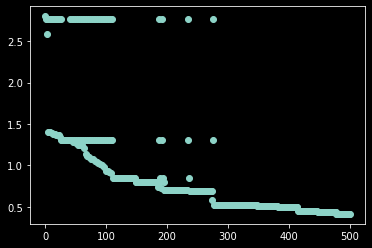

In [7]:
bn.add_nodes(info)
bn.add_edges(magic_niab, scoring_function=('BIC',))

In [9]:
with open('ecoli_true.txt') as f:
    lines = f.readlines()
true_net = []
for l in lines:
    e0 = l.split()[0]
    e1 = l.split()[1].split('\n')[0]
    true_net.append((e0, e1))

In [30]:
small_true_net = []
for e in true_net:
    if (e[0] in magic_niab.columns) & (e[1] in magic_niab.columns):
        small_true_net.append(e)

In [10]:
precision_recall(list(best_model_gmm_score_K2.edges()), true_net)

{'AP': 0.8, 'AR': 0.73, 'AHP': 0.55, 'AHR': 0.5, 'SHD': 48}

In [13]:
precision_recall(list(best_model_gmm_score.edges()), true_net)

{'AP': 0.87, 'AR': 0.56, 'AHP': 0.58, 'AHR': 0.37, 'SHD': 50}